# Market Features Data Availability Check

This notebook cell checks the date ranges for all market features datasets to ensure they are up to date. It will:

- Display the first and last available dates for each dataset
- Flag any datasets that are lagging behind the current date
- Show how many days behind each lagging dataset is

The following datasets are checked:
- Daily market breadth indicators
- Sector performance metrics
- Market sentiment (GDELT-based)
- Market volatility measures

Note: Some datasets (like GDELT sentiment) naturally lag by 1-2 days due to data source processing times. This is expected behavior and not an error.

Expected output format:  

```
Dataset Name:
First date: YYYY-MM-DD
Last date: YYYY-MM-DD ⚠️ X days behind (if applicable)
```

In [259]:
import os
import glob
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta

def print_date_range(df, name, reference_date=None):
    """Print the first and last dates for a DataFrame and flag if lagging."""
    if df.empty:
        print(f"{name}: No data available")
        return
        
    first_date = df.index[0].strftime('%Y-%m-%d')
    last_date = df.index[-1].strftime('%Y-%m-%d')
    
    # If no reference date provided, use the most recent date from any dataset
    if reference_date is None:
        reference_date = df.index[-1]
    
    # Calculate days behind
    days_behind = (reference_date - df.index[-1]).days
    
    # Format the output
    status = ""
    if days_behind > 0:
        status = f" ⚠️  {days_behind} day{'s' if days_behind != 1 else ''} behind"
    
    print(f"{name}:")
    print(f"  First date: {first_date}")
    print(f"  Last date:  {last_date}{status}")
    print()

# Get current date (or most recent trading day)
today = datetime.now().date()
if today.weekday() >= 5:  # If weekend, use Friday
    today = today - timedelta(days=today.weekday() - 4)

# Market breadth
market_breadth = pd.read_parquet('../data/market_features/daily_breadth.parquet')
print_date_range(market_breadth, "Daily Breadth", pd.Timestamp(today))

# Sector data
sector_files = glob.glob('../data/market_features/sectors/*.parquet')
sector_data = {}
for file in sector_files:
    sector_name = os.path.basename(file).replace('.parquet', '')
    sector_data[sector_name] = pd.read_parquet(file)
    print_date_range(sector_data[sector_name], f"Sector: {sector_name}", pd.Timestamp(today))

# Market sentiment
market_sentiment = pd.read_parquet('../data/market_features/market_sentiment.parquet')
print_date_range(market_sentiment, "Market Sentiment", pd.Timestamp(today))

# Market volatility
market_volatility = pd.read_parquet('../data/market_features/market_volatility.parquet')
print_date_range(market_volatility, "Market Volatility", pd.Timestamp(today))

Daily Breadth:
  First date: 2024-08-12
  Last date:  2025-06-06

Sector: energy:
  First date: 2024-08-12
  Last date:  2025-06-06

Sector: consumer_cyclical:
  First date: 2024-08-12
  Last date:  2025-06-06

Sector: communication_services:
  First date: 2024-08-12
  Last date:  2025-06-06

Sector: consumer_defensive:
  First date: 2024-08-12
  Last date:  2025-06-06

Sector: financial_services:
  First date: 2024-08-12
  Last date:  2025-06-06

Sector: healthcare:
  First date: 2024-08-12
  Last date:  2025-06-06

Sector: technology:
  First date: 2024-08-12
  Last date:  2025-06-06

Market Sentiment:
  First date: 2024-08-10
  Last date:  2025-06-06

Market Volatility:
  First date: 2024-08-12
  Last date:  2025-06-06



# Data Source Availability Check

This code checks the latest available data directly from the source providers for GDELT and VIX data. This is useful for:

- Verifying when new data becomes available
- Confirming if data lags are due to source availability or processing issues
- Planning when to run data updates
- Debugging data pipeline issues

The code checks:
- **GDELT**: Attempts to access the data files for the last 3 days to find the most recent available data
- **VIX**: Downloads the last 5 days of data from Yahoo Finance to confirm the latest available date


In [260]:
# import pandas as pd
# import yfinance as yf
# import requests
# from datetime import datetime, timedelta
# import logging
# import time

# # Configuration
# DAYS_TO_CHECK = 5  # Number of days to check for GDELT data
# VIX_LOOKBACK_DAYS = 5  # Number of days to check for VIX data

# # Set up logging
# logging.basicConfig(level=logging.INFO)
# logger = logging.getLogger(__name__)

# def check_gdelt_availability(days_to_check: int = DAYS_TO_CHECK):
#     """Check latest available GDELT data.
    
#     Args:
#         days_to_check: Number of days to check for available data
#     """
#     masterfile_url = "http://data.gdeltproject.org/gdeltv2/masterfilelist.txt"
#     base_url = "http://data.gdeltproject.org/gdeltv2/"
    
#     print(f"\nChecking GDELT data availability...")
    
#     try:
#         # First, get the masterfile list
#         print("Fetching GDELT masterfile list...")
#         response = requests.get(masterfile_url)
#         if response.status_code == 200:
#             # Parse the masterfile list
#             lines = response.text.split('\n')
#             available_dates = []
#             for line in lines:
#                 if line.strip() and '.export.CSV.zip' in line:
#                     # Extract date from filename
#                     date = line.split('/')[-1].split('.')[0]
#                     available_dates.append(date)
            
#             if available_dates:
#                 print("\nAvailable GDELT dates:")
#                 # Group by date (first 8 characters of timestamp)
#                 date_groups = {}
#                 for date in available_dates:
#                     day = date[:8]  # Get YYYYMMDD part
#                     if day not in date_groups:
#                         date_groups[day] = []
#                     date_groups[day].append(date)
                
#                 # Show last 10 days with their latest update
#                 for day in sorted(date_groups.keys())[-10:]:
#                     latest_update = max(date_groups[day])
#                     print(f"- {day} (latest update: {latest_update[8:10]}:{latest_update[10:12]})")
                
#                 # Get the most recent date and its latest update
#                 latest_day = max(date_groups.keys())
#                 latest_update = max(date_groups[latest_day])
                
#                 # Try to fetch the latest data
#                 url = f"{base_url}{latest_update}.export.CSV.zip"
#                 print(f"\nTrying to fetch latest data from: {url}")
                
#                 response = requests.get(url)
#                 if response.status_code == 200:
#                     print("Successfully accessed latest data")
#                     # Try to read a small sample to verify data is valid
#                     df = pd.read_csv(url, compression='zip', sep='\t', header=None, nrows=1)
#                     if not df.empty:
#                         print(f"Data sample loaded successfully")
#                         # Print the average tone for this date
#                         avg_tone = df[34].mean()  # Column 34 is the average tone
#                         print(f"Sample average tone: {avg_tone:.2f}")
#                         return latest_day
#                 else:
#                     print(f"Error accessing latest data (status code: {response.status_code})")
#             else:
#                 print("No GDELT data found in masterfile list")
#         else:
#             print(f"Error accessing masterfile list (status code: {response.status_code})")
#     except Exception as e:
#         print(f"Error checking GDELT availability: {str(e)}")
    
#     return None

# def check_vix_availability(lookback_days: int = VIX_LOOKBACK_DAYS):
#     """Check latest available VIX data.
    
#     Args:
#         lookback_days: Number of days to check for available data
#     """
#     try:
#         # Get VIX data for specified number of days
#         vix = yf.download('^VIX', 
#                          start=(datetime.now() - timedelta(days=lookback_days)).strftime('%Y-%m-%d'),
#                          end=datetime.now().strftime('%Y-%m-%d'))
#         if not vix.empty:
#             latest_date = vix.index[-1].strftime('%Y-%m-%d')
#             print(f"VIX data available for: {latest_date}")
#             return latest_date
#     except Exception as e:
#         logger.error(f"Error fetching VIX data: {e}")
#     return None

# print("Checking data availability...")
# print(f"\nGDELT Data (checking last {DAYS_TO_CHECK} days):")
# gdelt_date = check_gdelt_availability()

# print(f"\nVIX Data (checking last {VIX_LOOKBACK_DAYS} days):")
# vix_date = check_vix_availability()

# Market Features Overview -- Daily Breadth

This section explores key market features used in our analysis, including market breadth indicators, technical signals, and sector mappings. For detailed definitions, see [docs/market_features.md](../docs/market_features.md).

**Features include:**
- Advance-Decline Line
- New Highs and New Lows
- Percentage Above Moving Averages (MA20, MA50)
- RSI (Bullish, Oversold, Overbought)
- MACD Bullish
- Sector Mapping

In [268]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load market breadth data
market_breadth = pd.read_parquet('../data/market_features/daily_breadth.parquet')
market_breadth.tail()

,date,daily_breadth_adv_dec_line,daily_breadth_new_highs,daily_breadth_new_lows,daily_breadth_above_ma20,daily_breadth_above_ma50,daily_breadth_rsi_bullish,daily_breadth_rsi_oversold,daily_breadth_rsi_overbought,daily_breadth_macd_bullish
Date,,,,,,,,,,
2025-06-02,2025-06-02,3,0,0,5.0,0.0,80.0,0.0,5.0,75.0
2025-06-03,2025-06-03,3,0,0,5.0,0.0,80.0,0.0,5.0,75.0
2025-06-04,2025-06-04,3,0,0,5.0,0.0,70.0,0.0,10.0,75.0
2025-06-05,2025-06-05,3,0,0,5.0,0.0,60.0,5.0,10.0,70.0
2025-06-06,2025-06-06,3,0,0,5.0,0.0,65.0,0.0,5.0,75.0


## Data Summary

Below we display the structure and a sample of the market breadth data, including the date range and missing values.

In [269]:
print("Market Breadth Info:")
print(market_breadth.info())
print(market_breadth.tail())
print(f"\nDate range: {market_breadth.index.min()} to {market_breadth.index.max()}")
print(f"\nAny NaNs per column:\n{market_breadth.isna().sum()}")

Market Breadth Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 206 entries, 2024-08-12 to 2025-06-06
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date                          206 non-null    datetime64[ns]
 1   daily_breadth_adv_dec_line    206 non-null    int64         
 2   daily_breadth_new_highs       206 non-null    int64         
 3   daily_breadth_new_lows        206 non-null    int64         
 4   daily_breadth_above_ma20      206 non-null    float64       
 5   daily_breadth_above_ma50      206 non-null    float64       
 6   daily_breadth_rsi_bullish     206 non-null    float64       
 7   daily_breadth_rsi_oversold    206 non-null    float64       
 8   daily_breadth_rsi_overbought  206 non-null    float64       
 9   daily_breadth_macd_bullish    206 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 1

## Visualizing Market Breadth Indicators

We plot several key indicators to visualize market conditions over time.

In [270]:
market_breadth.columns

Index(['date', 'daily_breadth_adv_dec_line', 'daily_breadth_new_highs',
       'daily_breadth_new_lows', 'daily_breadth_above_ma20',
       'daily_breadth_above_ma50', 'daily_breadth_rsi_bullish',
       'daily_breadth_rsi_oversold', 'daily_breadth_rsi_overbought',
       'daily_breadth_macd_bullish'],
      dtype='object')

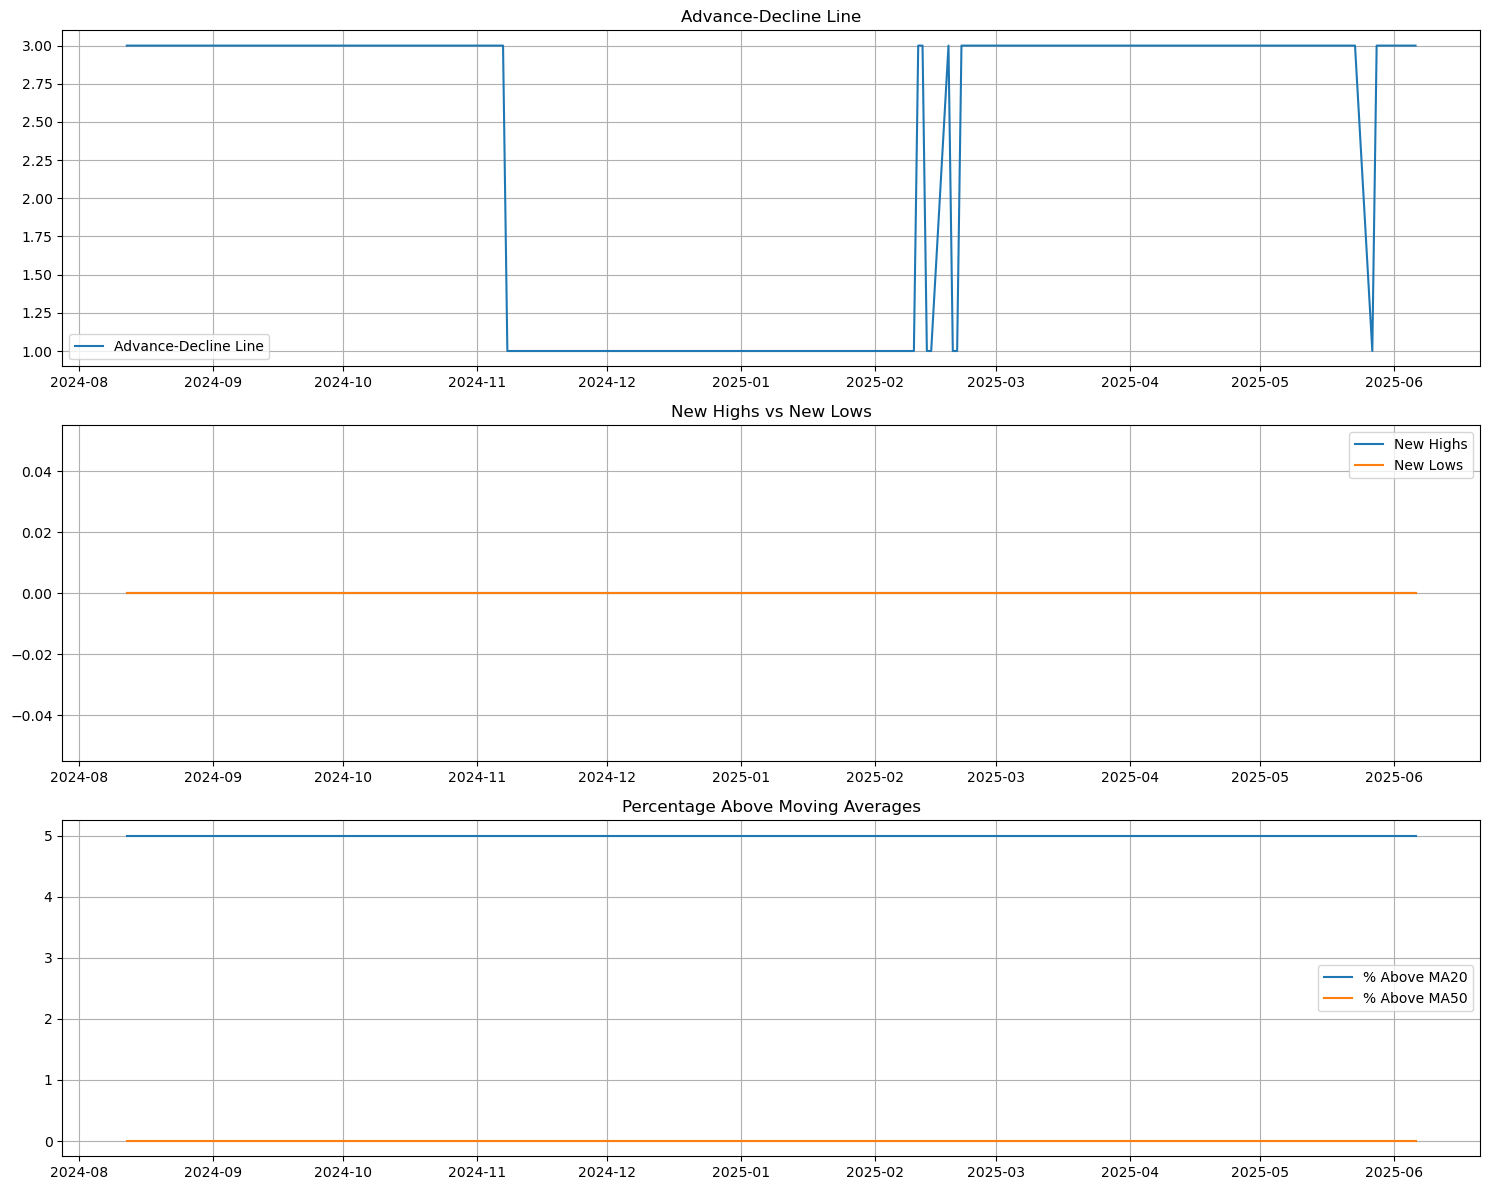

In [271]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Advance-Decline Line
axes[0].plot(market_breadth.index, market_breadth['daily_breadth_adv_dec_line'], label='Advance-Decline Line')
axes[0].set_title('Advance-Decline Line')
axes[0].legend()
axes[0].grid(True)

# New Highs and Lows
axes[1].plot(market_breadth.index, market_breadth['daily_breadth_new_highs'], label='New Highs')
axes[1].plot(market_breadth.index, market_breadth['daily_breadth_new_lows'], label='New Lows')
axes[1].set_title('New Highs vs New Lows')
axes[1].legend()
axes[1].grid(True)

# Percentage Above Moving Averages
axes[2].plot(market_breadth.index, market_breadth['daily_breadth_above_ma20'], label='% Above MA20')
axes[2].plot(market_breadth.index, market_breadth['daily_breadth_above_ma50'], label='% Above MA50')
axes[2].set_title('Percentage Above Moving Averages')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

## Technical Indicators

We also examine technical signals such as RSI and MACD bullishness.

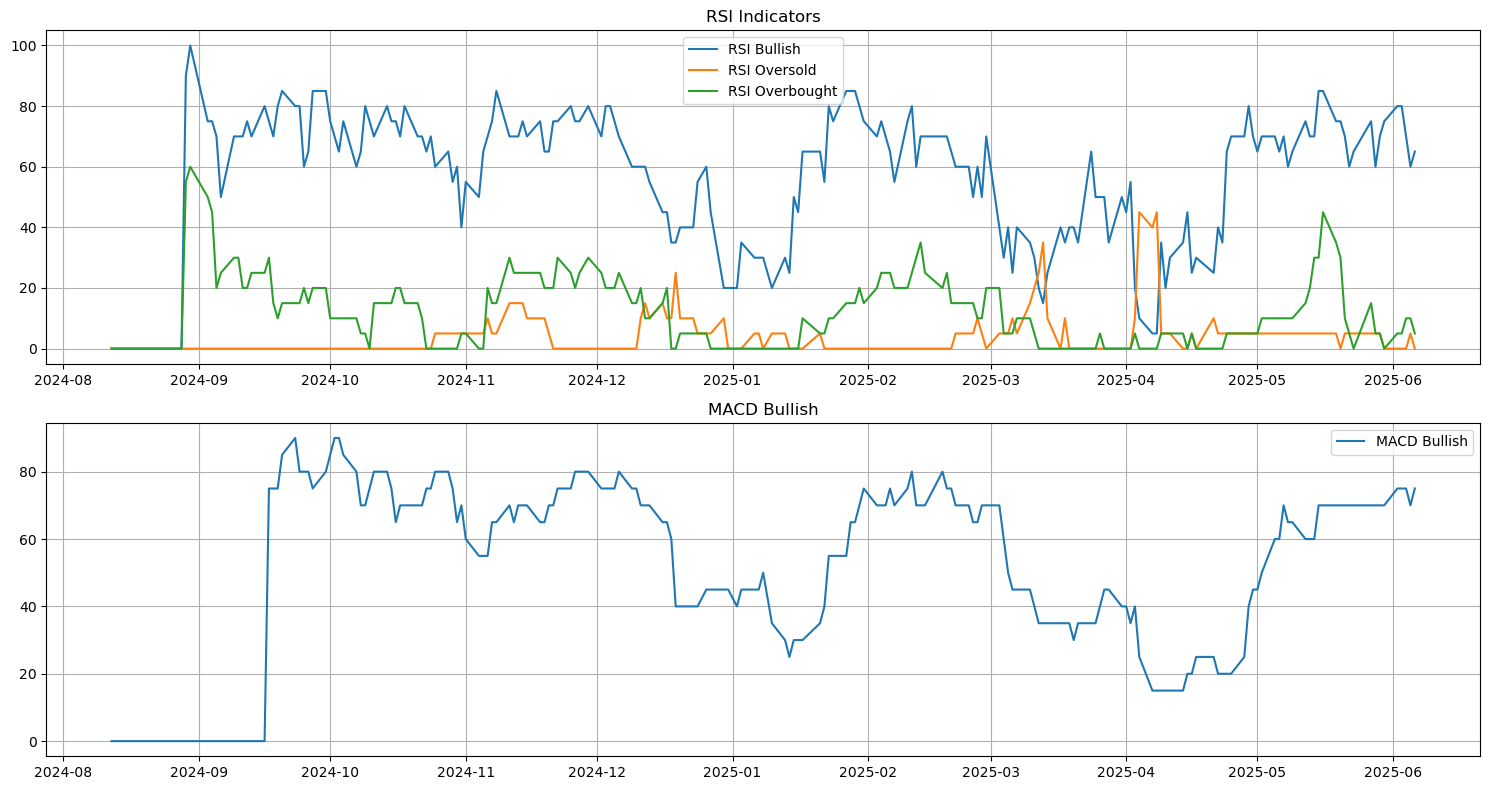

In [272]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# RSI indicators
axes[0].plot(market_breadth.index, market_breadth['daily_breadth_rsi_bullish'], label='RSI Bullish')
axes[0].plot(market_breadth.index, market_breadth['daily_breadth_rsi_oversold'], label='RSI Oversold')
axes[0].plot(market_breadth.index, market_breadth['daily_breadth_rsi_overbought'], label='RSI Overbought')
axes[0].set_title('RSI Indicators')
axes[0].legend()
axes[0].grid(True)

# MACD Bullish
axes[1].plot(market_breadth.index, market_breadth['daily_breadth_macd_bullish'], label='MACD Bullish')
axes[1].set_title('MACD Bullish')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Correlation Analysis

The following heatmap shows the correlation between different market features.

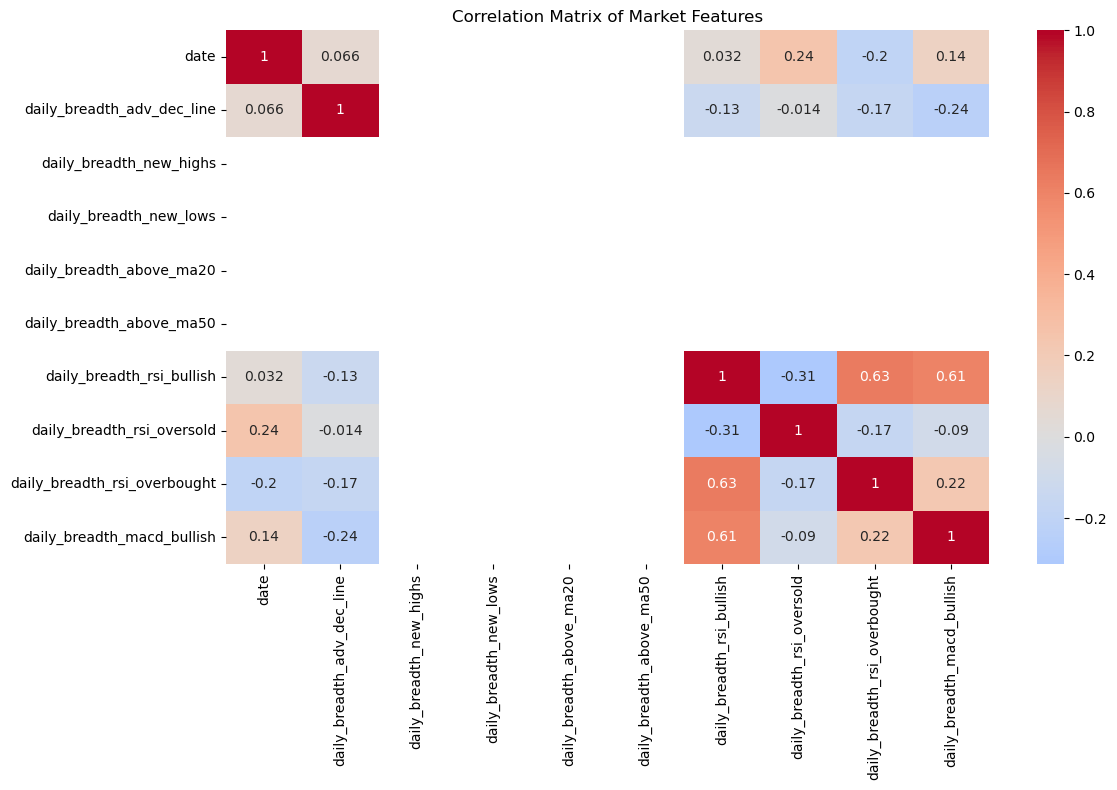

In [273]:
correlation_matrix = market_breadth.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Market Features')
plt.tight_layout()
plt.show()

## Summary Statistics

We compute summary statistics for all market features to understand their distributions.

In [274]:
summary_stats = market_breadth.describe()
display(summary_stats)

,date,daily_breadth_adv_dec_line,daily_breadth_new_highs,daily_breadth_new_lows,daily_breadth_above_ma20,daily_breadth_above_ma50,daily_breadth_rsi_bullish,daily_breadth_rsi_oversold,daily_breadth_rsi_overbought,daily_breadth_macd_bullish
count,206,206.000000,206.0,206.0,206.0,206.0,206.000000,206.000000,206.000000,206.000000
mean,2025-01-07 12:13:58.834951424,2.349515,0.0,0.0,5.0,0.0,55.849515,3.883495,11.577670,51.286408
min,2024-08-12 00:00:00,1.000000,0.0,0.0,5.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,2024-10-23 06:00:00,1.000000,0.0,0.0,5.0,0.0,40.000000,0.000000,0.000000,35.000000
50%,2025-01-07 12:00:00,3.000000,0.0,0.0,5.0,0.0,65.000000,0.000000,10.000000,65.000000
75%,2025-03-24 18:00:00,3.000000,0.0,0.0,5.0,0.0,75.000000,5.000000,20.000000,70.000000
max,2025-06-06 00:00:00,3.000000,0.0,0.0,5.0,0.0,100.000000,45.000000,60.000000,90.000000
std,NaN,0.939213,0.0,0.0,0.0,0.0,23.785252,7.034134,11.605772,26.469873


## Sector Mapping

Sector mapping links each ticker to its sector and subsector. For more, see [docs/market_features.md](../docs/market_features.md).

In [275]:
with open('../data/market_features/sector_mapping.json', 'r') as f:
    sector_dict = json.load(f)

sector_mapping = pd.DataFrame(list(sector_dict.items()), columns=['ticker', 'sector'])
display(sector_mapping.tail())
print(f"\n{sector_mapping['sector'].nunique()} distinct sectors:\n{sector_mapping['sector'].unique()}")

,ticker,sector
15,HD,Consumer Cyclical
16,JNJ,Healthcare
17,AAPL,Technology
18,MCD,Consumer Cyclical
19,MSFT,Technology



7 distinct sectors:
['Communication Services' 'Healthcare' 'Financial Services' 'Energy'
 'Consumer Defensive' 'Consumer Cyclical' 'Technology']


## Sector Performance Analysis

This section analyzes sector-level performance metrics including price, volatility, returns, and momentum indicators. The data is available in both individual sector files and a combined wide-format table.

In [276]:
technology = pd.read_parquet('../data/market_features/sectors/financial_services.parquet')
technology.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 206 entries, 2024-08-12 to 2025-06-06
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  206 non-null    datetime64[ns]
 1   financial_services_price              206 non-null    float64       
 2   financial_services_volatility         206 non-null    float64       
 3   financial_services_volume             206 non-null    int64         
 4   financial_services_returns_1d         205 non-null    float64       
 5   financial_services_returns_5d         201 non-null    float64       
 6   financial_services_returns_20d        186 non-null    float64       
 7   financial_services_momentum_5d        201 non-null    float64       
 8   financial_services_momentum_20d       186 non-null    float64       
 9   financial_services_relative_strength  167 non-null    flo

In [277]:
# Get list of all sector parquet files
sector_files = glob.glob('../data/market_features/sectors/*.parquet')

# Create a dictionary to store sector dataframes
sector_data = {}
for file in sector_files:
    sector_name = os.path.basename(file).replace('.parquet', '')
    sector_df = pd.read_parquet(file)
    print(sector_name)
    print(sector_df.iloc[-1])

energy
date                        2025-06-06 00:00:00
energy_price                         122.321896
energy_volatility                     25.373676
energy_volume                           9249434
energy_returns_1d                      0.024772
energy_returns_5d                      0.023614
energy_returns_20d                      0.01726
energy_momentum_5d                      0.00477
energy_momentum_20d                     0.00092
energy_relative_strength               1.281726
Name: 2025-06-06 00:00:00, dtype: object
consumer_cyclical
date                                   2025-06-06 00:00:00
consumer_cyclical_price                         326.236298
consumer_cyclical_volatility                     36.861639
consumer_cyclical_volume                         104807177
consumer_cyclical_returns_1d                      0.016355
consumer_cyclical_returns_5d                     -0.044748
consumer_cyclical_returns_20d                     0.020393
consumer_cyclical_momentum_5d            

In [278]:
sector_data.keys()

dict_keys([])

Sector Performance Data Info:

ENERGY Sector:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 206 entries, 2024-08-12 to 2025-06-06
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      206 non-null    datetime64[ns]
 1   energy_price              206 non-null    float64       
 2   energy_volatility         206 non-null    float64       
 3   energy_volume             206 non-null    int64         
 4   energy_returns_1d         205 non-null    float64       
 5   energy_returns_5d         201 non-null    float64       
 6   energy_returns_20d        186 non-null    float64       
 7   energy_momentum_5d        201 non-null    float64       
 8   energy_momentum_20d       186 non-null    float64       
 9   energy_relative_strength  167 non-null    float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 17.7 KB
None

Sample dat

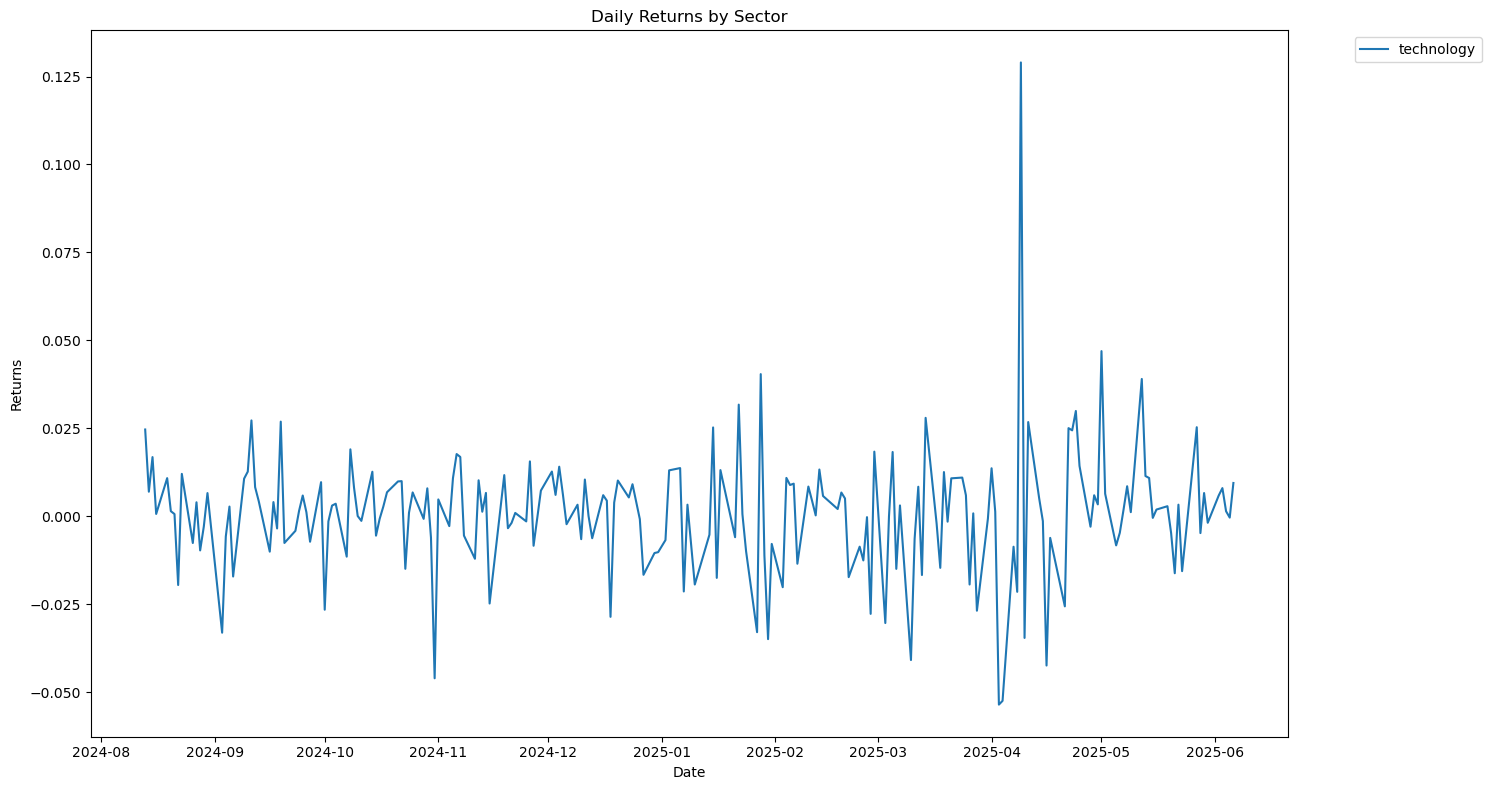

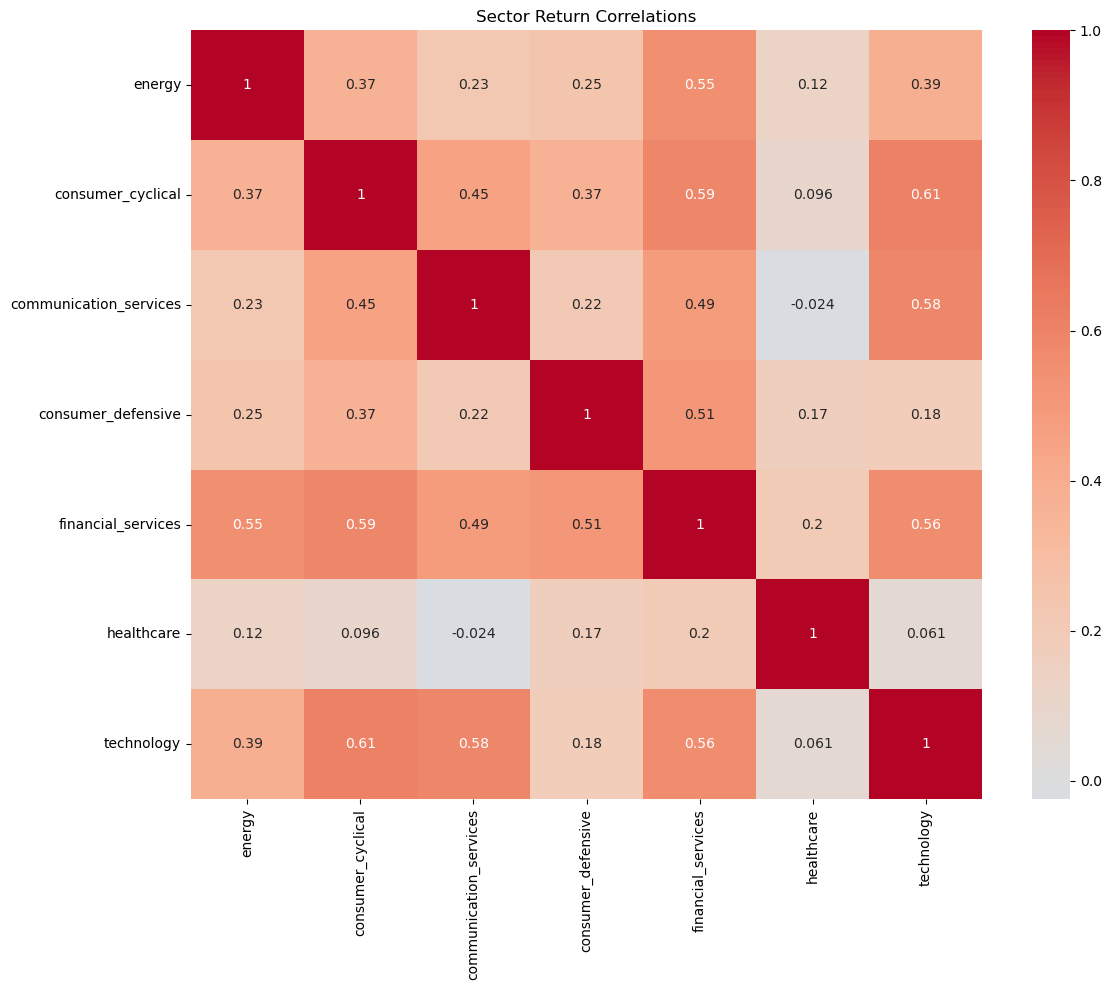

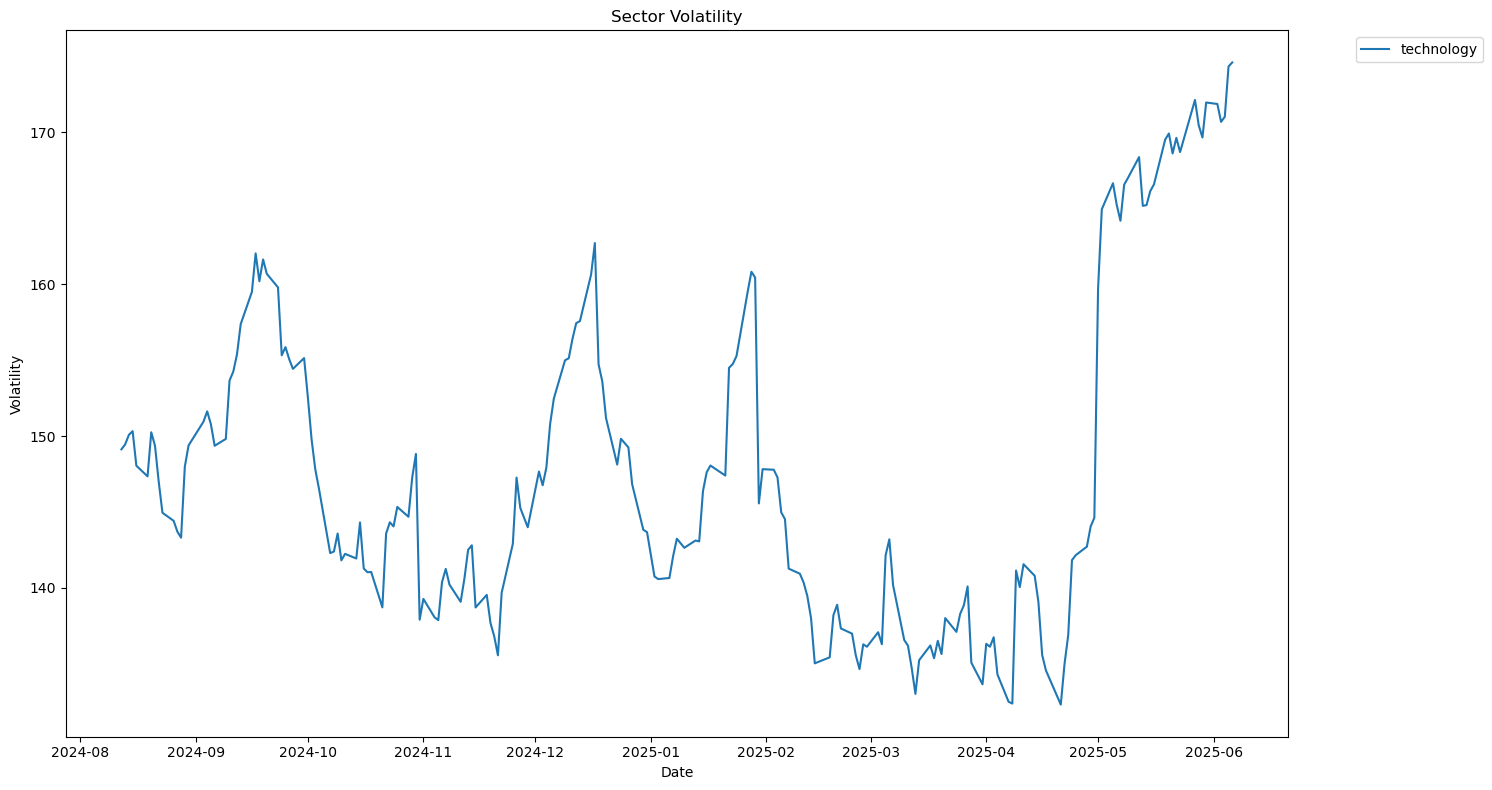

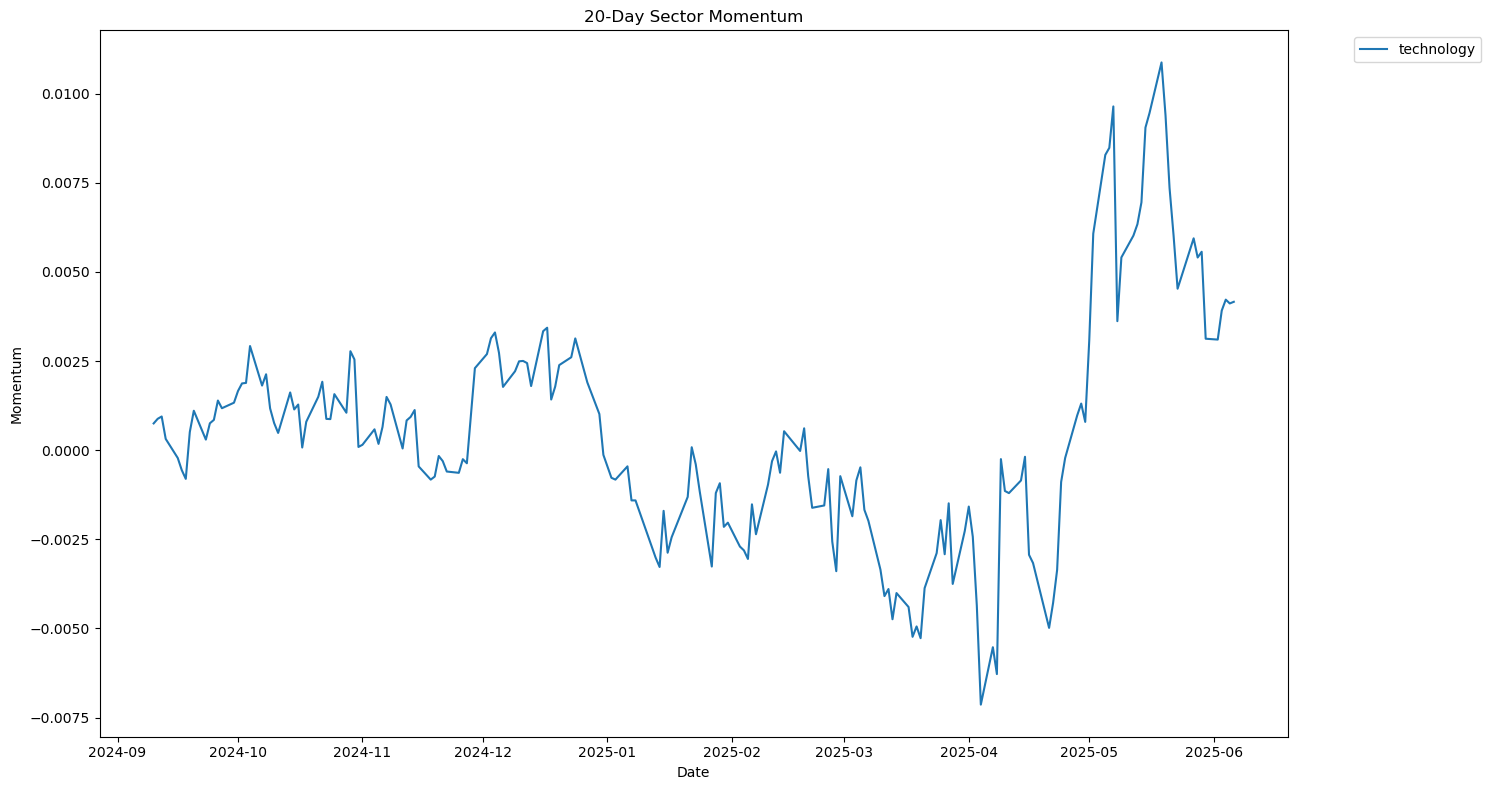


Volatility Statistics by Sector:
Empty DataFrame
Columns: []
Index: []


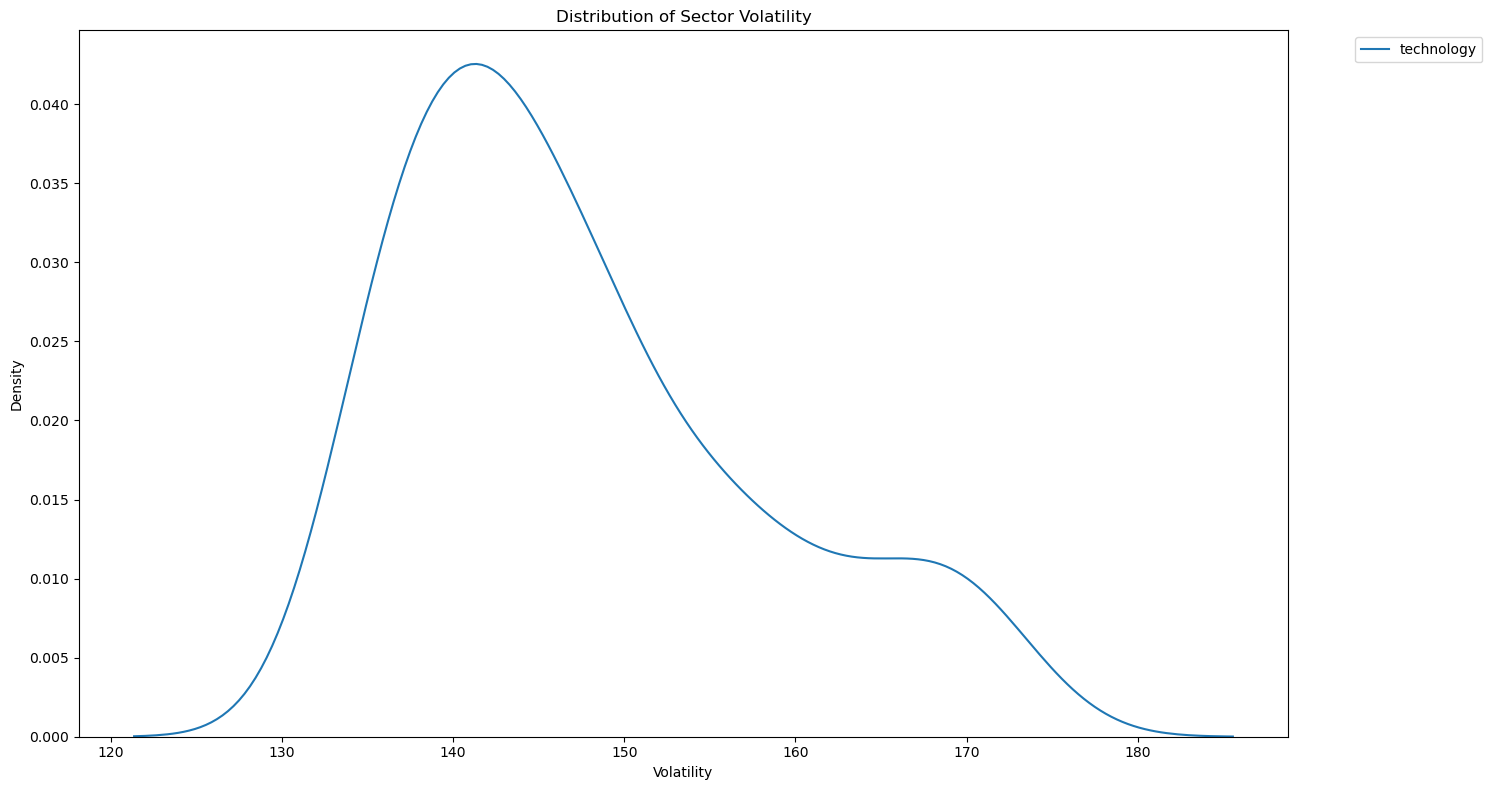

In [279]:
# Load sector performance data
import glob
import os

# Get list of all sector parquet files
sector_files = glob.glob('../data/market_features/sectors/*.parquet')

# Create a dictionary to store sector dataframes
sector_data = {}
for file in sector_files:
    sector_name = os.path.basename(file).replace('.parquet', '')
    sector_data[sector_name] = pd.read_parquet(file)

# Display basic information for each sector
print("Sector Performance Data Info:")
for sector, df in sector_data.items():
    print(f"\n{sector.upper()} Sector:")
    print(df.info())
    print("\nSample data:")
    print(df.tail())

# Create a visualization of sector returns
plt.figure(figsize=(15, 8))
for sector, df in sector_data.items():
    if sector_name + '_returns_1d' in df.columns:
        plt.plot(df.index, df[sector_name+'_returns_1d'], label=sector)
plt.title('Daily Returns by Sector')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calculate sector correlations
# First, create a combined dataframe of returns
returns_data = pd.DataFrame()
for sector, df in sector_data.items():
    if sector+'_returns_1d' in df.columns:
        returns_data[sector] = df[sector+'_returns_1d']

# Calculate and plot correlation matrix
correlation_matrix = returns_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Sector Return Correlations')
plt.tight_layout()
plt.show()

# Additional sector analysis
# Plot sector volatility
plt.figure(figsize=(15, 8))
for sector, df in sector_data.items():
    if sector_name+'_volatility' in df.columns:
        plt.plot(df.index, df[sector_name+'_volatility'], label=sector)
plt.title('Sector Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot sector momentum
plt.figure(figsize=(15, 8))
for sector, df in sector_data.items():
    if sector_name+'_momentum_20d' in df.columns:
        plt.plot(df.index, df[sector_name+'_momentum_20d'], label=sector)
plt.title('20-Day Sector Momentum')
plt.xlabel('Date')
plt.ylabel('Momentum')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Add this to your sector analysis section
# Calculate and compare volatility statistics
volatility_stats = {}
for sector, df in sector_data.items():
    if 'volatility' in df.columns:
        volatility_stats[sector] = {
            'mean': df[sector_name+'_volatility'].mean(),
            'std': df[sector_name+'_volatility'].std(),
            'max': df[sector_name+'_volatility'].max(),
            'min': df[sector_name+'_volatility'].min()
        }

# Create a comparison DataFrame
volatility_comparison = pd.DataFrame(volatility_stats).T
print("\nVolatility Statistics by Sector:")
print(volatility_comparison)

# Plot volatility distributions
plt.figure(figsize=(15, 8))
for sector, df in sector_data.items():
    if sector_name+'_volatility' in df.columns:
        sns.kdeplot(data=df[sector_name+'_volatility'], label=sector)
plt.title('Distribution of Sector Volatility')
plt.xlabel('Volatility')
plt.ylabel('Density')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Market Sentiment Analysis

This section explores market sentiment derived from GDELT news data, including sentiment moving averages, momentum, and volatility measures.

Market Sentiment Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 301 entries, 2024-08-10 to 2025-06-06
Data columns (total 6 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   date                                   301 non-null    datetime64[ns]
 1   market_sentiment_sentiment_ma5         297 non-null    float64       
 2   market_sentiment_sentiment_ma20        282 non-null    float64       
 3   market_sentiment_sentiment_momentum    296 non-null    float64       
 4   market_sentiment_sentiment_volatility  282 non-null    float64       
 5   market_sentiment_sentiment_zscore      282 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 16.5 KB
None

Sample of sentiment data:
                 date  market_sentiment_sentiment_ma5  \
date                                                    
2025-06-02 2025-06-02                      

KeyError: 'sentiment_ma5'

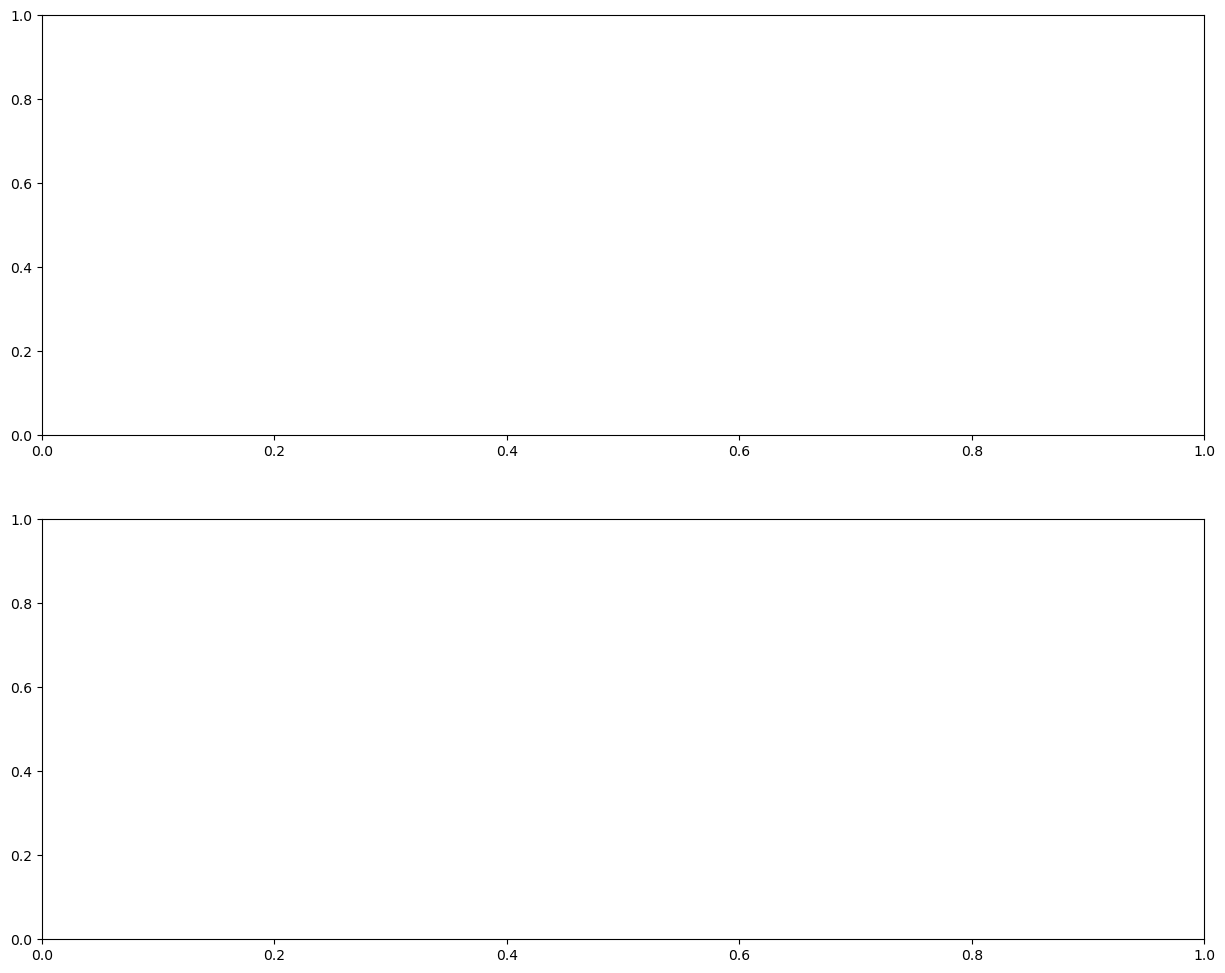

In [280]:
# Load market sentiment data
sentiment_data = pd.read_parquet('../data/market_features/market_sentiment.parquet')

# Display basic information
print("Market Sentiment Data Info:")
print(sentiment_data.info())
print("\nSample of sentiment data:")
print(sentiment_data.tail())

# Create sentiment visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot sentiment moving averages
ax1.plot(sentiment_data.index, sentiment_data['sentiment_ma5'], label='5-day MA')
ax1.plot(sentiment_data.index, sentiment_data['sentiment_ma20'], label='20-day MA')
ax1.set_title('Sentiment Moving Averages')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment')
ax1.legend()

# Plot sentiment momentum and volatility
ax2.plot(sentiment_data.index, sentiment_data['sentiment_momentum'], label='Momentum')
ax2.plot(sentiment_data.index, sentiment_data['sentiment_volatility'], label='Volatility')
ax2.set_title('Sentiment Momentum and Volatility')
ax2.set_xlabel('Date')
ax2.set_ylabel('Value')
ax2.legend()

plt.tight_layout()
plt.show()

# Plot sentiment z-score
plt.figure(figsize=(15, 6))
plt.plot(sentiment_data.index, sentiment_data['sentiment_zscore'])
plt.axhline(y=2, color='r', linestyle='--', label='Overbought')
plt.axhline(y=-2, color='g', linestyle='--', label='Oversold')
plt.title('Sentiment Z-Score')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.tight_layout()
plt.show()

## Market Volatility Analysis

This section examines various volatility indicators including VIX metrics, market-wide volatility measures, and cross-sectional volatility statistics.

In [283]:
volatility_data.columns

Index(['date', 'market_volatility_daily_volatility',
       'market_volatility_weekly_volatility',
       'market_volatility_monthly_volatility',
       'market_volatility_avg_correlation', 'market_volatility_ticker'],
      dtype='object')

Market Volatility Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4120 entries, 2024-08-12 to 2025-06-06
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  4120 non-null   datetime64[ns]
 1   market_volatility_daily_volatility    4080 non-null   float64       
 2   market_volatility_weekly_volatility   4020 non-null   float64       
 3   market_volatility_monthly_volatility  3720 non-null   float64       
 4   market_volatility_avg_correlation     4020 non-null   float64       
 5   market_volatility_ticker              4120 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 225.3+ KB
None

Sample of volatility data:
                 date  market_volatility_daily_volatility  \
Date                                                        
2025-06-02 2025-06-02      

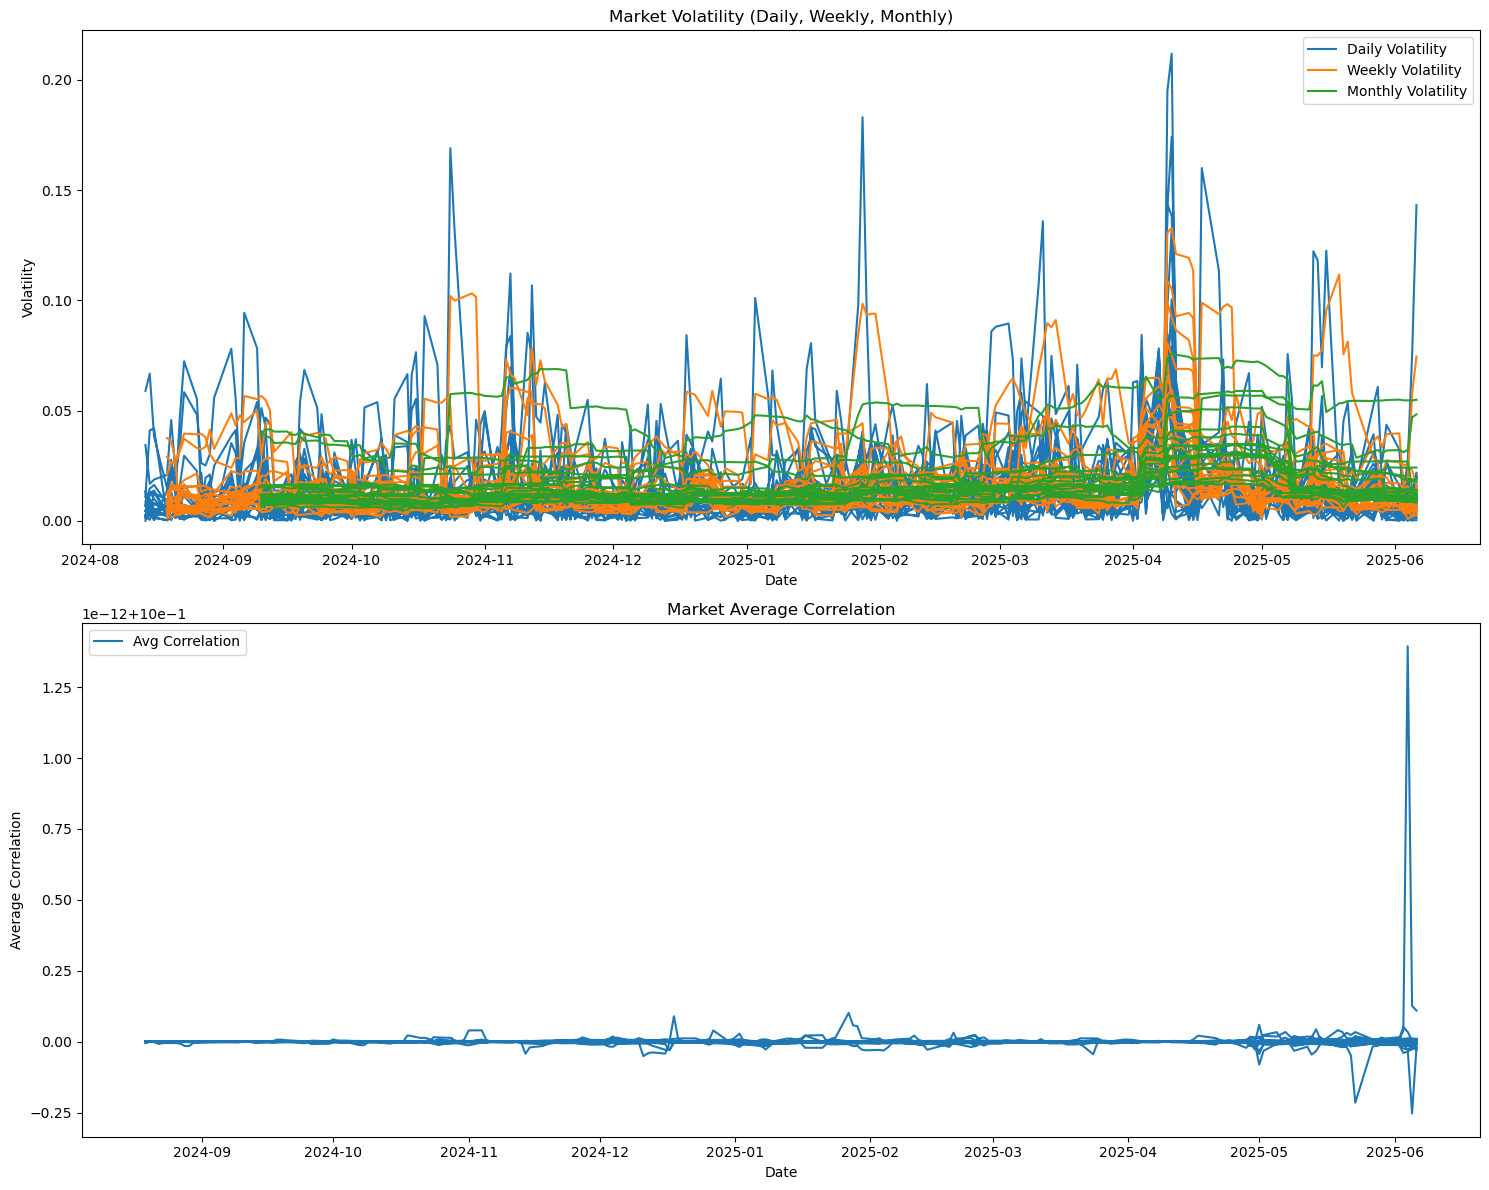

In [289]:
import pandas as pd
import matplotlib.pyplot as plt

# Load market volatility data
volatility_data = pd.read_parquet('../data/market_features/market_volatility.parquet')

# Display basic information
print("Market Volatility Data Info:")
print(volatility_data.info())
print("\nSample of volatility data:")
print(volatility_data.tail())

# Ensure 'date' is the index for plotting
if 'date' in volatility_data.columns:
    volatility_data['date'] = pd.to_datetime(volatility_data['date'])
    volatility_data.set_index('date', inplace=True)

# Create volatility visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot daily, weekly, and monthly volatility
ax1.plot(volatility_data.index, volatility_data['market_volatility_daily_volatility'], label='Daily Volatility')
ax1.plot(volatility_data.index, volatility_data['market_volatility_weekly_volatility'], label='Weekly Volatility')
ax1.plot(volatility_data.index, volatility_data['market_volatility_monthly_volatility'], label='Monthly Volatility')
ax1.set_title('Market Volatility (Daily, Weekly, Monthly)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility')
ax1.legend()

# Plot average correlation
ax2.plot(volatility_data.index, volatility_data['market_volatility_avg_correlation'], label='Avg Correlation')
ax2.set_title('Market Average Correlation')
ax2.set_xlabel('Date')
ax2.set_ylabel('Average Correlation')
ax2.legend()

plt.tight_layout()
plt.show()